Данные библиотеки нужно установить для работы ноутбука.

In [2]:
# !pip install -U torch
# !pip install torchtext
# !pip install transformers==3.0.0

     |████████████████████████████████| 757kB 8.7MB/s 
     |████████████████████████████████| 890kB 17.6MB/s 
     |████████████████████████████████| 1.2MB 36.7MB/s 
     |████████████████████████████████| 3.0MB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7be6ff147b383e6232f1a89a5e095d878df758cd75d0f2bc12d84b323d7e1a99
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import random
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
import pandas as pd

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel

from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

In [4]:
print(transformers.__version__) # should be 3.0.0

3.0.0


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Скачиваем данные

In [6]:
# Download dataset
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2021-01-19 13:47:00--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2021-01-19 13:47:00--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  80.5MB/s    in 1.0s    

2021-01-19 13:47:01 (80.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


## Read data
Считываем датасет Sentiment140. Датасет состоит из твитов из Twitter, всего 160,000 твитов.

Описание: http://help.sentiment140.com/for-students/

- Первая колонка - polarity, 0 - negative, 4 - positive, 2 - neutral (нейтральная окраска встречается только в тесте, ее не будем рассматривать)
- Последняя колонка - текст твита

In [8]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Read test data

In [9]:
df_test = pd.read_csv("testdata.manual.2009.06.14.csv", encoding = "ISO-8859-1", header=None)
df_test.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


Посмотрим на распределение ответов в данных и тестовых данных.

In [10]:
np.unique(df[0], return_counts=True)

(array([0, 4]), array([800000, 800000]))

In [11]:
np.unique(df_test[0], return_counts=True)

(array([0, 2, 4]), array([177, 139, 182]))

Split data to train, validation, test

In [12]:
data = np.array(df[5])
target = np.array(df[0])
# change target value of 4 to 1
target[target == 4] = 1

#shuffle the data
data, target = shuffle(data, target)

#split data to train and validation
data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=0.33)


data_test = np.array(df_test[5])
target_test = np.array(df_test[0])

#remove test object with neutral setniment
data_test = data_test[target_test != 2]
target_test = target_test[target_test != 2]
# change target value of 4 to 1
target_test[target_test == 4] = 1

In [13]:
print("Train: {} elements".format(len(data_train)))
print("Validation: {} elements".format(len(data_val)))
print("Test: {} elements".format(len(data_test)))

Train: 1072000 elements
Validation: 528000 elements
Test: 359 elements


## Data preprocessing

В качестве модели возьмем предобученный Bert. Bert обучался на большом корпусе данных на двух задачах:
- По двум предложениям предсказывать является ли второе предложение следующим за первым.
- MaskedLM(маскированная языковая модель): маскируются некоторые слова входного предложения, требуется предсказать замаскированные слова.

Для работы с Bert нам нужно сделать такую же предобработку данных, что использовалась при предобученнии.


1. Добавляем специальные токены `[CLS]` и `[SEP]` в начало и конец предложения соответственно.

*Пример:*

`[CLS] предложение A [SEP] предложение B [SEP]`


In [15]:
data_train = ["[CLS] " + text + " [SEP]" for text in data_train]
data_test = ["[CLS] " + text + " [SEP]" for text in data_test]
data_val = ["[CLS] " + text + " [SEP]" for text in data_val]

2. С помощью токенизатора для BERT'а превратим наши текстовые данные в набор токенов из словаря предобученной модели.

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_train = [tokenizer.tokenize(text) for text in tqdm(data_train)]
tokenized_test = [tokenizer.tokenize(text) for text in tqdm(data_test)]
tokenized_val = [tokenizer.tokenize(text) for text in tqdm(data_val)]

3. Преобразуем токены в их индексы в словаре BERT'а.

In [17]:
ids_train = [tokenizer.convert_tokens_to_ids(text) for text in tqdm(tokenized_train)]
ids_test = [tokenizer.convert_tokens_to_ids(text) for text in tqdm(tokenized_test)]
ids_val = [tokenizer.convert_tokens_to_ids(text) for text in tqdm(tokenized_val)]

Пример работы всего препроцессинга.

In [19]:
example_sent = "That is the worst thing happened  I'll tell you tomorrow when I see you."
print("Init text:   ", example_sent)
example_sent = "[CLS] " + example_sent + " [SEP]"
print("Text:        ", example_sent)
tokens = tokenizer.tokenize(example_sent)
print("Tokenization:", tokens)
print("Indices:     ", tokenizer.convert_tokens_to_ids(tokens))

Init text:    That is the worst thing happened  I'll tell you tomorrow when I see you.
Text:         [CLS] That is the worst thing happened  I'll tell you tomorrow when I see you. [SEP]
Tokenization: ['[CLS]', 'that', 'is', 'the', 'worst', 'thing', 'happened', 'i', "'", 'll', 'tell', 'you', 'tomorrow', 'when', 'i', 'see', 'you', '.', '[SEP]']
Indices:      [101, 2008, 2003, 1996, 5409, 2518, 3047, 1045, 1005, 2222, 2425, 2017, 4826, 2043, 1045, 2156, 2017, 1012, 102]


BERT работает со входными данными одной длины. Построим гистограмму длин предложений.

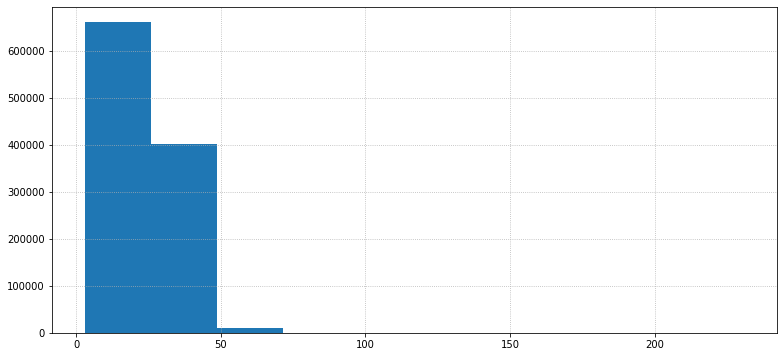

Min length: 3
Max length: 231
99.5% percentile 52.0


In [20]:
train_lengths = [len(text) for text in ids_train]

plt.figure(figsize=(13, 6))
plt.hist(train_lengths)
plt.grid(ls=":")
plt.show()

print("Min length:", np.min(train_lengths))
print("Max length:", np.max(train_lengths))
print("99.5% percentile", np.percentile(train_lengths, 99.5))

Обрезаем слишком длинные тексты, дополняем падингом слишком короткие.

In [21]:
MAX_LEN = 52

padding = lambda texts: pad_sequences(texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# apply padding и truncation 
ids_train = padding(ids_train)
ids_test = padding(ids_test)
ids_val = padding(ids_val)

Заполняем attention mask: последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг. Bert использует ее внутри.

In [22]:
get_attention_masks = lambda input_ids: [[float(i > 0) for i in seq] for seq in input_ids]

attention_mask_train = get_attention_masks(ids_train)
attention_mask_test = get_attention_masks(ids_test)
attention_mask_val = get_attention_masks(ids_val)

## Fit the model

Создаем torch тензоры для данных.

In [23]:
X_train = torch.tensor(ids_train).to(device)
X_val = torch.tensor(ids_val).to(device)
X_test = torch.tensor(ids_test).to(device)

mask_train = torch.tensor(attention_mask_train).to(device)
mask_val = torch.tensor(attention_mask_val).to(device)
mask_test = torch.tensor(attention_mask_test).to(device)

y_train = torch.tensor(target_train, dtype=torch.float32).to(device)
y_val = torch.tensor(target_val, dtype=torch.float32).to(device)
y_test = torch.tensor(target_test, dtype=torch.float32).to(device)

Создаем DataLoader-ы, которые будут генерировать батчи для обучения.

In [24]:
batch_size = 16

train_data = TensorDataset(X_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, mask_val, y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, mask_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Создаем модель. Для этого берем предобученную модель Bert и добавляем к ней свои голову для бинарной классифкации.

In [25]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self):
        super(BertForSentimentAnalysis, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.dense = nn.Linear(self.bert.config.hidden_size, 1)
        
    def forward(self, inds, mask):
        _, x = self.bert(inds, mask)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [26]:
bert_model = BertForSentimentAnalysis()

Будем дообучать сразу все слои используя оптимизатор AdamW(Adam algorithm with weight decay) и лоссом Binary cross-entropy.

In [27]:
bert_model = bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss().to(device)

In [46]:
from IPython.display import clear_output

def plot_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title('loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('accuracy', fontsize=15)
    plt.plot(history['accuracy']['train'], label='train')
    plt.plot(history['accuracy']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()
    

def train(model, optimizer, criterion, train_batch_gen, val_batch_gen, num_epochs=10):
    history = defaultdict(lambda: defaultdict(list))
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()
        
        for inds_batch, mask_batch, target_batch in tqdm(train_batch_gen):
            inds_batch = inds_batch.to(device)
            mask_batch = mask_batch.to(device)
            target_batch = target_batch.to(device)
            
            logits = model(inds_batch, mask_batch).squeeze(1)
            # print(logits.is_cuda, target_batch.is_cuda)
            loss = criterion(logits, target_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            predictions = torch.round(torch.sigmoid(logits))
            correct = (predictions == target_batch).float()
            train_acc += correct.sum() / len(correct)
            
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['accuracy']['train'].append(train_acc)
        
        
        model.train(False)
        for inds_batch, mask_batch, target_batch in tqdm(val_batch_gen):
            inds_batch = inds_batch.to(device)
            mask_batch = mask_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(inds_batch, mask_batch).squeeze(1)
                loss = criterion(logits, target_batch)
            
            val_loss += np.sum(loss.detach().cpu().numpy())
            predictions = torch.round(torch.sigmoid(logits))
            correct = (predictions == target_batch).float()
            val_acc += correct.sum() / len(correct)
 
            
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['accuracy']['val'].append(val_acc)
        
        
        clear_output()
        
        print("epoch {} of {}: {:.4f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("train loss:   {:.6f}".format(train_loss))
        print("val loss (in-iteration):   {:.6f}".format(val_loss))
        print("train accuracy:   {:.2f} %".format(train_acc * 100))
        print("val accuracy:   {:.2f} %".format(val_acc * 100))
        
        plot_curves(history)
        
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            print("saving")
            torch.save(model.state_dict(), 'model.pt')
        
    return model, history

epoch 1 of 1: 10024.6776s
train loss:   0.318684
val loss (in-iteration):   0.312203
train accuracy:   86.30 %
val accuracy:   86.66 %


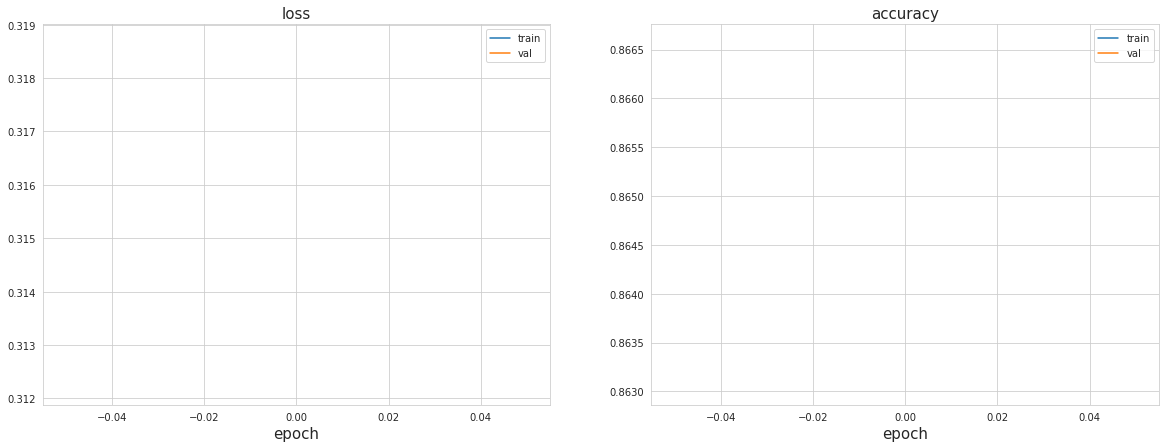

saving


In [47]:
model, history = train(bert_model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs=1)

In [49]:
# save model to google drive (if you run in google colab)
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/My Drive/model.pt')

Mounted at /content/drive


## Оценим качество модели на тесте

In [57]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

bert_model.eval()
test_predictions = []
test_labels = []

for inds_batch, mask_batch, target_batch in tqdm(test_dataloader, total=len(test_data)/batch_size):
    inds_batch = inds_batch.to(device)
    mask_batch = mask_batch.to(device)
    target_batch = target_batch.to(device)
    with torch.no_grad():
        logits = model(inds_batch, mask_batch).squeeze(1)


    predictions = torch.round(torch.sigmoid(logits)).detach().cpu().numpy()
    
    test_predictions.extend(predictions)
    test_labels.extend(target_batch.detach().cpu().numpy())
    

print('Accuracy: {0:.4f}%, Precision: {1:.3f}%, Recall: {2:.3f}%'.format(
    accuracy_score(test_labels, test_predictions) * 100,
    precision_score(test_labels, test_predictions) * 100,
    recall_score(test_labels, test_predictions) * 100
))


Accuracy: 86.0724%, Precision: 84.021%, Recall: 89.560%
